In [62]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import nltk

In [63]:
# Read the data
df = pd.read_csv('AmazonReviews/Reviews.csv')

In [64]:
df.head()
print(df.shape)
df = df.head(500)
print(df.shape)

(568454, 10)
(500, 10)


## Quick EDA

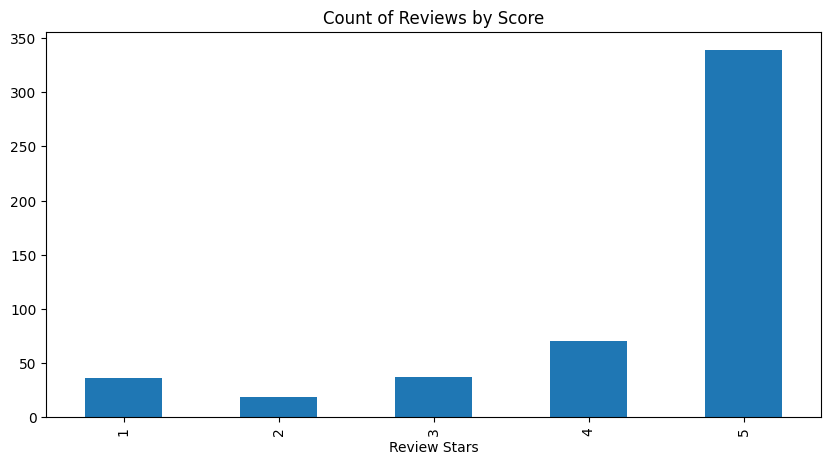

In [65]:
ax = df['Score'].value_counts().sort_index() \
    .plot(kind='bar', title='Count of Reviews by Score', figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

## Basic NLTK

In [66]:
example = df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [67]:
tokens = nltk.word_tokenize(example)
print(tokens)

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft', ',', 'I', 'do', "n't", 'like', 'it', '.', 'Quaker', 'Oats', 'is', 'the', 'way', 'to', 'go', '.']


In [68]:
tagged = nltk.pos_tag(tokens)
print(tagged)

[('This', 'DT'), ('oatmeal', 'NN'), ('is', 'VBZ'), ('not', 'RB'), ('good', 'JJ'), ('.', '.'), ('Its', 'PRP$'), ('mushy', 'NN'), (',', ','), ('soft', 'JJ'), (',', ','), ('I', 'PRP'), ('do', 'VBP'), ("n't", 'RB'), ('like', 'VB'), ('it', 'PRP'), ('.', '.'), ('Quaker', 'NNP'), ('Oats', 'NNPS'), ('is', 'VBZ'), ('the', 'DT'), ('way', 'NN'), ('to', 'TO'), ('go', 'VB'), ('.', '.')]


In [69]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


## VADER Sentiment Scoring